# Focal Lossの実装と効果の確認
https://take-tech-engineer.com/pytorch-focal-loss/

In [ ]:
import torch
from torch import nn

class Focal_MultiLabel_Loss(nn.Module):
    def __init__(self, gamma):
      super(Focal_MultiLabel_Loss, self).__init__()
      self.gamma = gamma
      self.bceloss = nn.BCELoss(reduction='none')

    def forward(self, outputs, targets): 
      bce = self.bceloss(torch.clamp(outputs, 1e-4, 1-1e-4), targets)
      bce_exp = torch.exp(-bce)
      focal_loss = (1-bce_exp)**self.gamma * bce
      return focal_loss.mean()

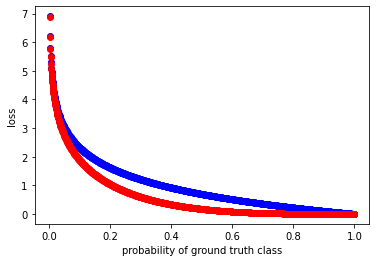

In [ ]:
import matplotlib.pyplot as plt

# binary cross entropy
loss = nn.BCELoss(reduction='none')
target = torch.Tensor([1])
for input in torch.arange(0.001, 1, 0.001):
  output = loss(input, target[0])
  plt.scatter(input, output, color = "blue")

# focal loss γ=2
loss = Focal_MultiLabel_Loss(gamma=2)
for input in torch.arange(0.001, 1, 0.001):
  output = loss(input, target[0])
  plt.scatter(input, output, color = "red")

plt.xlabel('probability of ground truth class')
plt.ylabel('loss');

In [ ]:
import pandas as pd

raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
display(raw_df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
import numpy as np
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [ ]:
from sklearn.model_selection import train_test_split

cleaned_df = raw_df.copy()

cleaned_df.pop('Time')

eps = 0.001
cleaned_df['LogAmount'] = np.log(cleaned_df.pop('Amount') + eps)

train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=0)

train_labels = np.array(train_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
test_features = np.array(test_df)

from torch.utils.data import DataLoader

batch_size = 64

train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_features).to(torch.float32), torch.tensor(train_labels.astype(np.float32)).unsqueeze(1))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(test_features).to(torch.float32), torch.tensor(test_labels.astype(np.float32)).unsqueeze(1))
train_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(29, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [ ]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = SimpleNet().to(device)

criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        # print(X)
        # print(pred)
        # print(y)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\\n-------------------------------")
    train(train_dataloader, model, criterion, optimizer)
print("Done!")

Using cuda device
Epoch 1\n-------------------------------
loss: 0.785133  [    0/56962]
loss: 0.318656  [ 6400/56962]
loss: 0.058717  [12800/56962]
loss: 0.033004  [19200/56962]
loss: 0.012521  [25600/56962]
loss: 0.007392  [32000/56962]
loss: 0.003354  [38400/56962]
loss: 0.002652  [44800/56962]
loss: 0.002203  [51200/56962]
Epoch 2\n-------------------------------
loss: 0.001425  [    0/56962]
loss: 0.001311  [ 6400/56962]
loss: 0.000930  [12800/56962]
loss: 0.046329  [19200/56962]
loss: 0.001130  [25600/56962]
loss: 0.000551  [32000/56962]
loss: 0.000957  [38400/56962]
loss: 0.001216  [44800/56962]
loss: 0.001136  [51200/56962]
Epoch 3\n-------------------------------
loss: 0.000264  [    0/56962]
loss: 0.000390  [ 6400/56962]
loss: 0.000584  [12800/56962]
loss: 0.000428  [19200/56962]
loss: 0.000754  [25600/56962]
loss: 0.000312  [32000/56962]
loss: 0.000856  [38400/56962]
loss: 0.039027  [44800/56962]
loss: 0.000301  [51200/56962]
Epoch 4\n-------------------------------
loss: 0.

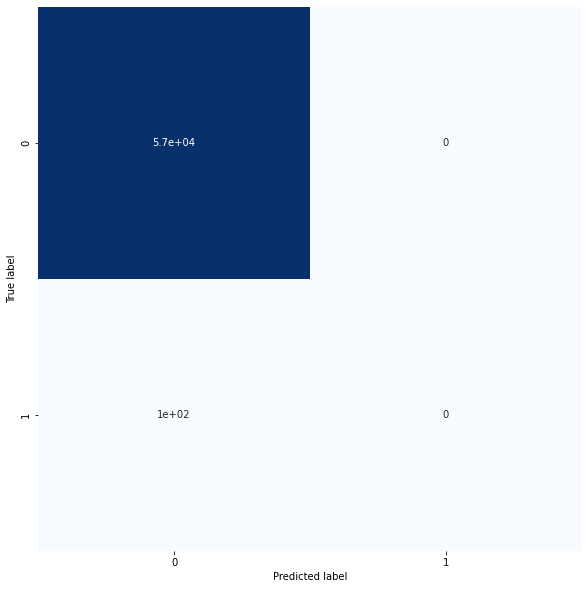

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = []
Y = []
model.eval()

for x, y in val_dataloader:
    with torch.no_grad():
        output = model(x.to(device))
    pred += [1 if output > 0.5 else 0]
    Y += [int(l) for l in y]

# 混同行列表示用
def plot_confusion_matrix(true, predicted):
    cm = confusion_matrix(true, predicted)
    fig, ax = plt.subplots(figsize = (10,10))
    sns.heatmap(cm, square=True, cbar=False, annot=True, cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

plot_confusion_matrix(Y, pred)

Epoch 1\n-------------------------------
loss: 0.060887  [    0/56962]
loss: 0.005862  [ 6400/56962]
loss: 0.001130  [12800/56962]
loss: 0.000987  [19200/56962]
loss: 0.000296  [25600/56962]
loss: 0.001060  [32000/56962]
loss: 0.000203  [38400/56962]
loss: 0.000164  [44800/56962]
loss: 0.000137  [51200/56962]
Epoch 2\n-------------------------------
loss: 0.000081  [    0/56962]
loss: 0.000891  [ 6400/56962]
loss: 0.000158  [12800/56962]
loss: 0.000176  [19200/56962]
loss: 0.000027  [25600/56962]
loss: 0.000109  [32000/56962]
loss: 0.000106  [38400/56962]
loss: 0.000035  [44800/56962]
loss: 0.000057  [51200/56962]
Epoch 3\n-------------------------------
loss: 0.000426  [    0/56962]
loss: 0.000027  [ 6400/56962]
loss: 0.000081  [12800/56962]
loss: 0.000021  [19200/56962]
loss: 0.000017  [25600/56962]
loss: 0.000068  [32000/56962]
loss: 0.000078  [38400/56962]
loss: 0.000019  [44800/56962]
loss: 0.000042  [51200/56962]
Epoch 4\n-------------------------------
loss: 0.000030  [    0/569

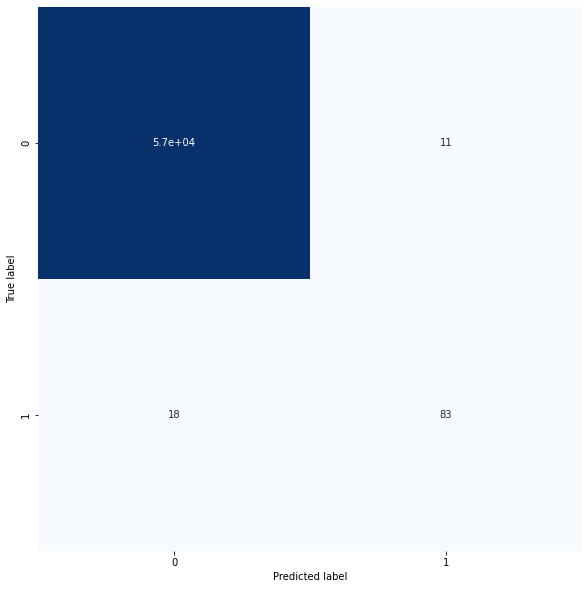

In [ ]:
model = SimpleNet().to(device)

criterion = Focal_MultiLabel_Loss(gamma=4) # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1}\\n-------------------------------")
    train(train_dataloader, model, criterion, optimizer)
print("Done!")

pred = []
Y = []
model.eval()
for x, y in val_dataloader:
    with torch.no_grad():
        output = model(x.to(device))
    pred += [1 if output > 0.5 else 0]
    Y += [int(l) for l in y]

plot_confusion_matrix(Y, pred)